## Loan Approval Model


### Problem Statement

Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customers first apply for a home loan after that company manually validates the customer eligibility for loan.
Company wants to automate the loan eligibility process based on customer detail provided while filling the details online.
They need a web application where a user can access their website and register, login, and enter the required details such as Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others for checking the eligibility for the home loan

### Objective:
Predicting whether the loan can be approved to a customer based on the details provided.


### Attribute Information:
1. **loan_id** - Unique Loan ID
2. **gender**  - Male or Female
3. **married** - Applicant married (Y/N)
4. **dependents** - Number of dependents
5. **education** - Graduate/Undergraduate
6. **self_employed** - Self employed (Y/N)
7. **applicantincome** - Applicant income (in dollars)
8. **coapplicantincome** - Co Applicant Income (in dollars)
9. **loanamount**- Loan amount in thousands (in dollars)
10. **loan_amount_term** - Term of loan in months
11. **credit_history** - Credit history meets guidelines Yes/No(1/0)
12. **property_area** - Urban/Semi Urban/Rural
13. **loan_status** - (Target) Loan Approved (Y/N)

### 1. Import required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Check the first few samples, shape, info of the data and try to familiarize yourself with different features

In [2]:
df = pd.read_csv('loan_approval_data.csv')
df.head()

,loan_id,gender,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,loan_status
0,lp001002,male,no,0.0,graduate,no,5849,0.0,NaN,360.0,1.0,urban,y
1,lp001003,male,yes,1.0,graduate,no,4583,1508.0,128.0,360.0,1.0,rural,n
2,lp001005,male,yes,0.0,graduate,yes,3000,0.0,66.0,360.0,1.0,urban,y
3,lp001006,male,yes,0.0,not graduate,no,2583,2358.0,120.0,360.0,1.0,urban,y
4,lp001008,male,no,0.0,graduate,no,6000,0.0,141.0,360.0,1.0,urban,y


In [3]:
## lets check the basic information of the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loan_id            614 non-null    object 
 1   gender             601 non-null    object 
 2   married            611 non-null    object 
 3   dependents         599 non-null    float64
 4   education          614 non-null    object 
 5   self_employed      582 non-null    object 
 6   applicantincome    614 non-null    int64  
 7   coapplicantincome  614 non-null    float64
 8   loanamount         592 non-null    float64
 9   loan_amount_term   600 non-null    float64
 10  credit_history     564 non-null    float64
 11  property_area      614 non-null    object 
 12  loan_status        614 non-null    object 
dtypes: float64(5), int64(1), object(7)
memory usage: 62.5+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
dependents,599.0,0.762938,1.015216,0.0,0.0,0.0,2.00,3.0
applicantincome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
coapplicantincome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
loanamount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
loan_amount_term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
credit_history,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


In [5]:
df.describe(include = 'O').T

,count,unique,top,freq
loan_id,614,614,lp001002,1
gender,601,2,male,489
married,611,2,yes,398
education,614,2,graduate,480
self_employed,582,2,no,500
property_area,614,3,semiurban,233
loan_status,614,2,y,422


In [6]:
len(df[df.duplicated()])

0

In [7]:
df['credit_history'].value_counts()

1.0    475
0.0     89
Name: credit_history, dtype: int64

### 3. Check for missing values in the dataset, if present? handle them with appropriate methods and drop redundant features 

In [8]:
percent_missing = df.isnull().sum() * 100 / len(df)
print(percent_missing)

loan_id              0.000000
gender               2.117264
married              0.488599
dependents           2.442997
education            0.000000
self_employed        5.211726
applicantincome      0.000000
coapplicantincome    0.000000
loanamount           3.583062
loan_amount_term     2.280130
credit_history       8.143322
property_area        0.000000
loan_status          0.000000
dtype: float64


We can see that the following features have missing values 
 - credit_history 
 - self-employed
 - loanamount 
 - loan_amount_term
 - dependents 
 - gender 
 - married

In [9]:
def fill_empty_values_randomly(feature_name,possible_values_list):
    mask = df[feature_name].isnull()
    #count rows with NaNs
    l = mask.sum()
    #create array with size l
    s = np.random.choice(possible_values_list, size=l)
    #set NaNs values
    df.loc[mask, feature_name] = s

In [10]:
#Credit history is either 0 or 1 so we cannot replace the null values with mean so 
# we are going to select randomly from 1,0 and add it to the list. 
fill_empty_values_randomly('credit_history',[1,0])

# credit histroy takes a value as 0 or 1 
df['credit_history'] = df['credit_history'].astype(int)

In [11]:
#self_employed is either yes or no so we cannot replace the null values with mean so 
# we are going to select randomly from 'yes' or 'no'  and add it to the list. 
fill_empty_values_randomly('self_employed',['yes','no'])

In [12]:
def fill_empty_values_with_mean(feature_name):
    feature_mean=df[feature_name].mean()
    df[feature_name].fillna(value=feature_mean, inplace=True)

In [13]:
fill_empty_values_with_mean('loanamount')

In [14]:
fill_empty_values_with_mean('loan_amount_term')

In [15]:
#dependents cannot be a float value so we cannot replace it with mean 
#so we are going to select the values randomly from 0,1,2,3
fill_empty_values_randomly('dependents',[0,1,2,3])

In [16]:
fill_empty_values_randomly('gender',['male','female'])

In [17]:
fill_empty_values_randomly('married',['yes','no'])

In [18]:
df['total_income'] = df['applicantincome']+ df['coapplicantincome']

In [19]:
df = df.astype({"dependents":"int","total_income":"int","loan_amount_term":"int","loanamount":"int"})

In [20]:
percent_missing = df.isnull().sum() * 100 / len(df)
print(percent_missing)

loan_id              0.0
gender               0.0
married              0.0
dependents           0.0
education            0.0
self_employed        0.0
applicantincome      0.0
coapplicantincome    0.0
loanamount           0.0
loan_amount_term     0.0
credit_history       0.0
property_area        0.0
loan_status          0.0
total_income         0.0
dtype: float64


In [21]:
## dropping the column "loan_id"
df = df.drop(columns=['loan_id','applicantincome','coapplicantincome'],axis = 1)

In [22]:
df = df.rename(columns = {"loanamount": "loan_amount"})

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            614 non-null    object
 1   married           614 non-null    object
 2   dependents        614 non-null    int32 
 3   education         614 non-null    object
 4   self_employed     614 non-null    object
 5   loan_amount       614 non-null    int32 
 6   loan_amount_term  614 non-null    int32 
 7   credit_history    614 non-null    int32 
 8   property_area     614 non-null    object
 9   loan_status       614 non-null    object
 10  total_income      614 non-null    int32 
dtypes: int32(5), object(6)
memory usage: 40.9+ KB


In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
dependents,614.0,0.781759,1.030336,0.0,0.00,0.0,2.00,3.0
loan_amount,614.0,146.397394,84.037503,9.0,100.25,129.0,164.75,700.0
loan_amount_term,614.0,342.000000,64.372489,12.0,360.00,360.0,360.00,480.0
credit_history,614.0,0.815961,0.387832,0.0,1.00,1.0,1.00,1.0
total_income,614.0,7024.703583,6458.664751,1442.0,4166.00,5416.5,7521.75,81000.0


In [25]:
df.describe(include = 'O').T

,count,unique,top,freq
gender,614,2,male,495
married,614,2,yes,399
education,614,2,graduate,480
self_employed,614,2,no,515
property_area,614,3,semiurban,233
loan_status,614,2,y,422


###  4. Visualize the distribution of the target column 'loan_status' with respect to various categorical features and write your observations. 

In [26]:
def plot_categorical(feature):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='loan_status', data=df)
    plt.title(f'Distribution of {feature} by loan_status')
    plt.show()

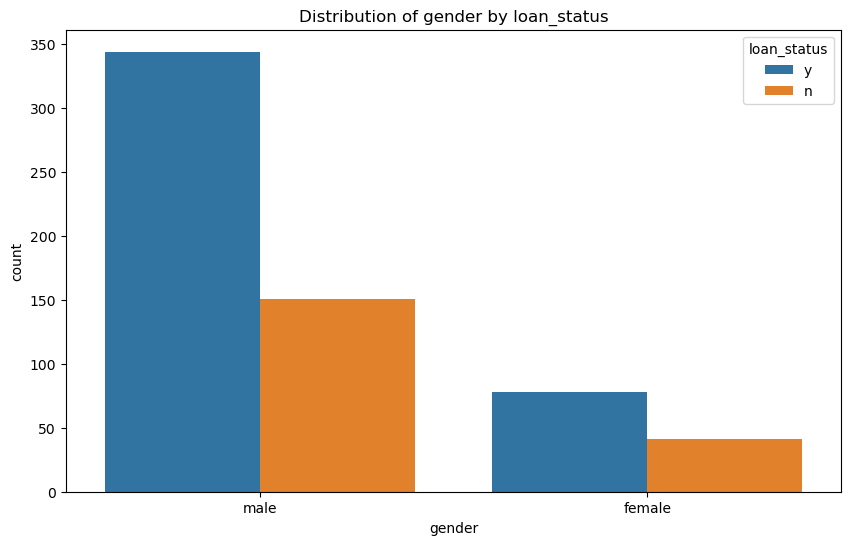

In [27]:
plot_categorical('gender')

- Males are more likely elgible for loans than females

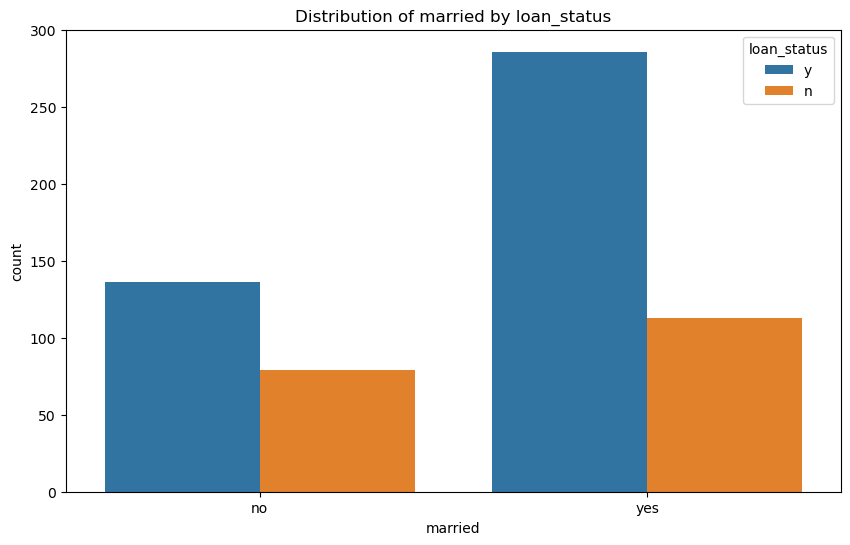

In [28]:
plot_categorical('married')


- On an average most of the married applicants are elgible for loan.

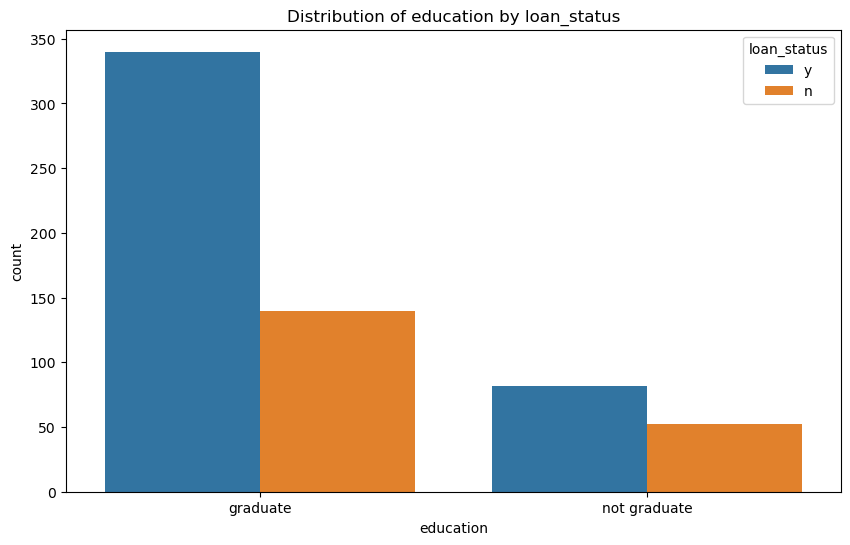

In [29]:
plot_categorical('education')


- it is diffcult for a non-graduate to be elgible for loan.

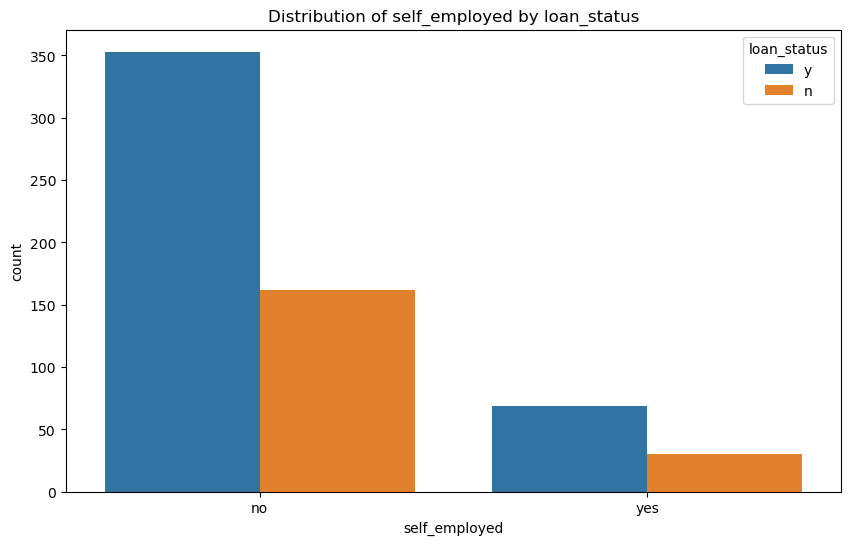

In [30]:
plot_categorical('self_employed')


- The probability for a non self-employeed individual to be elgible for loan is high.

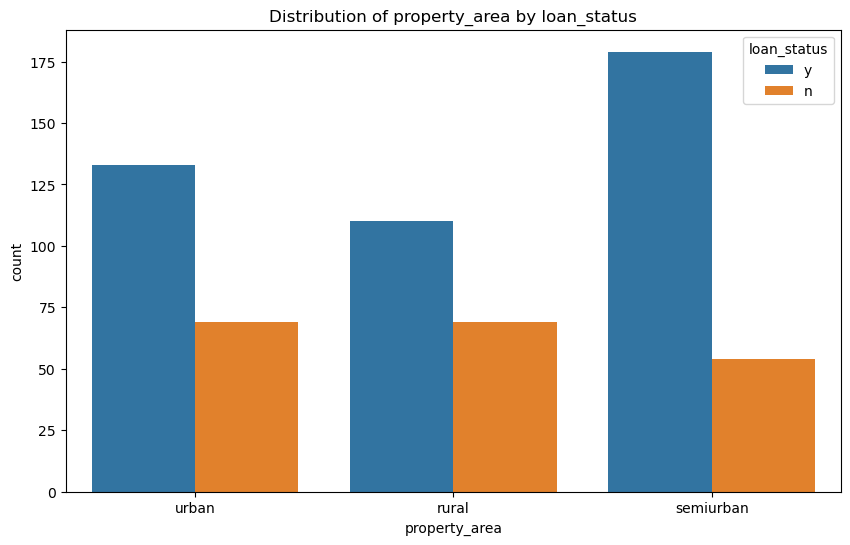

In [31]:
plot_categorical('property_area')

- if you are living in the semiurban area, you are more likely to be eligible for a loan.

The following are the inferences 
- You are elgible for a loan in most of the cases if you are a male,married,gradute and non-self employed and live in a semi urban area.

### 5 Encode the categorical data 

In [32]:
categorical_columns = ['gender','married','education','self_employed','loan_status','property_area']
le = LabelEncoder()
for i in categorical_columns:
        df[i] = df[[i]].apply(le.fit_transform)
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print("Mapping of column",i,"is",le_name_mapping)

Mapping of column gender is {'female': 0, 'male': 1}
Mapping of column married is {'no': 0, 'yes': 1}
Mapping of column education is {'graduate': 0, 'not graduate': 1}
Mapping of column self_employed is {'no': 0, 'yes': 1}
Mapping of column loan_status is {'n': 0, 'y': 1}
Mapping of column property_area is {'rural': 0, 'semiurban': 1, 'urban': 2}


In [33]:
df.head()

,gender,married,dependents,education,self_employed,loan_amount,loan_amount_term,credit_history,property_area,loan_status,total_income
0,1,0,0,0,0,146,360,1,2,1,5849
1,1,1,1,0,0,128,360,1,0,0,6091
2,1,1,0,0,1,66,360,1,2,1,3000
3,1,1,0,1,0,120,360,1,2,1,4941
4,1,0,0,0,0,141,360,1,2,1,6000


### 6. Separate the target and independent features and split the data into train and test

In [34]:
X = df.drop('loan_status',axis=1)
y = df['loan_status']

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=112)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(491, 10) (123, 10)
(491,) (123,)


### 7. Build any classification model to predict the loan status of the customer and save your model using pickle

In [36]:
## Let us build simple random forest regressor model
rf = RandomForestClassifier(n_estimators =30 , random_state =229)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=30, random_state=229)

In [37]:
## Let us check the r2-score to see hows our model is performing

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

accuracy_train = accuracy_score(y_train,y_train_pred)
accuracy_test = accuracy_score(y_test,y_test_pred)

print('accuray-score train:',accuracy_train)
print('accuracy-score test',accuracy_test)

accuray-score train: 0.9959266802443992
accuracy-score test 0.7560975609756098


#### Pickling - Creating a pickle file with an extension as .pkl

In [38]:
import pickle
# Saving model to disk
pickle.dump(rf, open('loan_estimator.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('loan_estimator.pkl','rb'))

--------
### Happy Learning :)
--------